<a href="https://colab.research.google.com/github/mikful/audio-app-mf-ct/blob/master/model_colab_dev.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Audio classification model training - Freesound 2019 Kaggle Competition dataset

* Model - pretrained fastai2 xresnet50 using fastai2 audio library
* Dataset - Curated Train Set from Kaggle Freesound 2019 Competition, multi-label 80 classes


**fastai2_audio**

The additional requirements of the fastai2_audio package will be dealt with below, using a clone of the following repo:

https://github.com/rbracco/fastai2_audio

The demo was run and tested by deploying an SageMaker Notebook instance as per the instructions outlined [here] (https://forums.fast.ai/t/platform-amazon-sagemaker-aws/66020).

Note - the above link is only accessible as part of the ongoing fastai course for the time being.

In [1]:
# See runtime gpu info
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Select the Runtime → "Change runtime type" menu to enable a GPU accelerator, ')
  print('and then re-execute this cell.')
else:
  print(gpu_info)

Tue May  5 20:46:17 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 440.82       Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   45C    P0    29W / 250W |      0MiB / 16280MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                       GPU Memory |
|  GPU  

## Mount Google drive and Unzip data

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
!unzip -d '../content/train_curated' -qq  "/content/drive/My Drive/Machine_Learning/My_Projects/19009 - Freesound 2019/train_curated.zip"

In [0]:
!cp "/content/drive/My Drive/Machine_Learning/My_Projects/19009 - Freesound 2019/train_curated.csv" '../content' 

In [6]:
import os
files = os.listdir('../content/train_curated')
len(files)

4970

## COLAB ONLY - INSTALL FASTAI2

In [7]:
#Run once per session
#In Colab we need to run this as a notebook command )i.e. no '!' infront of 'pip'
#This is in comparison to shell commands i.e. with '!' infront of 'pip'
pip install fastai2

     |████████████████████████████████| 194kB 6.4MB/s 


## Install the fastai2_audio library

We need to install the fastai2_audio library to the local kernel/environment for the analysis

Note the lack of `!pip` (that install to the root env) but rather standard `pip` (that installs to the current kernl/env)...

In [8]:
#In Colab we need to run this as a shell command i.e. with '!' infront of 'pip'

!pip install git+https://github.com/mikful/fastai2_audio.git

  Cloning https://github.com/mikful/fastai2_audio.git to /tmp/pip-req-build-ixpjmniv
  Running command git clone -q https://github.com/mikful/fastai2_audio.git /tmp/pip-req-build-ixpjmniv
     |████████████████████████████████| 3.2MB 6.2MB/s 
  Created wheel for fastai2-audio: filename=fastai2_audio-0.0.1-cp36-none-any.whl size=15764 sha256=e41264d5edbedd90fafa779fe291ba0ca909a4336e8c40ab99ed247794a57962
  Stored in directory: /tmp/pip-ephem-wheel-cache-bo7y5bty/wheels/21/78/26/cd4f9a6750539feda2dab7cbe11110f74ebadaff3c863f8b51
  Created wheel for colorednoise: filename=colorednoise-1.1.1-cp36-none-any.whl size=3958 sha256=424728e1886da2a91ba8b05ba117d436480ab6899de627268c6d4849ab6f5145
  Stored in directory: /root/.cache/pip/wheels/84/be/f3/3e7e1c80ebab3f6f0dbd3e34e787b902d2280d66706485fef4
Successfully built fastai2-audio colorednoise


In [0]:
# Solving an OSError problem with Librosa SoundFile dependency (libsndfile)
# SageMaker/GCP Only

# !conda install -c conda-forge libsndfile --yes

# Train the fastai model
First we will train our fastai model on the notebook instance using the kernel named `fastai2`.

The audio package analysis follows guidance given within: https://github.com/muellerzr/Practical-Deep-Learning-for-Coders-2.0/blob/master/Computer%20Vision/07_Audio.ipynb

In [0]:
from fastai2.vision.all import *
from fastai2_audio.core import *
from fastai2_audio.augment import *

**Create Dataframes from csv files**

**Note: Delete Corrupted and empty files list in Kaggle Competition Note**

*The following 5 audio files in the curated train set have a wrong label, due to a bug in the file renaming process: f76181c4.wav, 77b925c2.wav, 6a1f682a.wav, c7db12aa.wav, 7752cc8a.wav*

*The audio file 1d44b0bd.wav in the curated train set was found to be corrupted (contains no signal) due to an error in format conversion.*

In [0]:
# Create train_curated Dataframe

def create_train_curated_df(file, remove_files=[]):
    df_curated = pd.read_csv(file)
    df_curated.set_index('fname', inplace=True)
    df_curated.loc[remove_files]
    df_curated.drop(index=remove_files, inplace=True)
    df_curated.reset_index(inplace=True)
    return df_curated

In [18]:
# Create Curated training set df

# Remove corrupt and empty files as per Kaggle

remove_files = ['f76181c4.wav', '77b925c2.wav', '6a1f682a.wav', 'c7db12aa.wav', '7752cc8a.wav', '1d44b0bd.wav']
df_curated = create_train_curated_df('../content/train_curated.csv', remove_files=remove_files)
df_curated.head()

,fname,labels
0,0006ae4e.wav,Bark
1,0019ef41.wav,Raindrop
2,001ec0ad.wav,Finger_snapping
3,0026c7cb.wav,Run
4,0026f116.wav,Finger_snapping


In [19]:
df_curated.describe()

,fname,labels
count,4964,4964
unique,4964,213
top,dfd87955.wav,Gong
freq,1,75


**Now define the data paths**

First we're going to try to train with the curated train set only to see the performance. Then we can mix both the curated and noise train set to see the results.

In [0]:
fnames = df_curated['fname']

In [21]:
fnames[:5]

0    0006ae4e.wav
1    0019ef41.wav
2    001ec0ad.wav
3    0026c7cb.wav
4    0026f116.wav
Name: fname, dtype: object

In [0]:
fdir = '../content/train_curated'
fpaths = [Path(fdir,df_curated['fname'][ind]) for ind in df_curated.index]

In [23]:
len(fpaths)

4964

## Using the DataBlock API:

* We'll want to use our same transforms we used for the Pipeline
* An appropriate getter
* An appropriate labeller

The following datablock method references the new and wonderful **"Fastbook"** by fastai:

https://github.com/fastai/fastbook/blob/master/06_multicat.ipynb

and the above mentioned Audio notebook by Z Mueller.

> ### Constructing a data block
>
>How do we convert from a DataFrame object to a DataLoaders object? PyTorch and fastai have two main classes for representing and accessing a training set or validation set:
>
>* **Dataset**:: a collection which returns a tuple of your independent and dependent variable for a single item
>* **DataLoader**:: an iterator which provides a stream of mini batches, where each mini batch is a couple of a batch of independent variables and a batch of dependent variables
>
>On top of these, fastai provides two classes for bringing your training and validation sets together:
>
>* **Datasets**:: an object which contains a training Dataset and a validation Dataset
>* **DataLoaders**:: an object which contains a training DataLoader and a validation DataLoader
>
>Since a DataLoader builds on top of a Dataset, and adds additional functionality to it (collating multiple items into a mini batch), it’s often easiest to start by creating and testing Datasets, and then look at DataLoaders after that’s working.


The files in this case have multi-labels within the 'labels' column of the dataframe. 

So we will need to set the multi-labels appropriately in training.

First, we create a "datasets" object from our dataframe:


## Data Augmentation

We can use the `SpectrogramTransformer` class to prepare some transforms for us.

We need to open the audio file and convert to mel-spectrogramtensors.


In [24]:
def get_x(r): return '../content/train_curated/'+r['fname']
def get_y(r): return r['labels'].split(',') # split labels on ','
dblock = DataBlock(get_x = get_x, get_y = get_y)
dsets = dblock.datasets(df_curated)
dsets.train[0]

('../content/train_curated/45d213a0.wav', ['Clapping'])

In [0]:
DBMelSpec = SpectrogramTransformer(mel=True, to_db=True)

In [0]:
clip_length = 2 # clip subsection length in seconds
sr = 44100 # sample rate
f_min = 20 # mel-spectrogram minimum frequency
f_max = 20000 # mel-spectrogram minimum frequency
n_mels = 128 # mel-frequency bins
hop_length = math.ceil((clip_length*sr)/n_mels)# determines width of image. for square to match n_mels, set math.ceil((clip_length*sr)/n_mels)
nfft = n_mels * 20 # = 2560 for higher resolution in y-axis
win_length = 1024 # sample windowing
top_db = 80 # highest noise level in relative db

In [29]:
cfg = AudioConfig.BasicMelSpectrogram()
aud2spec = AudioToSpec.from_cfg(cfg)
aud2spec = DBMelSpec(sample_rate=sr, win_length=win_length, 
                     f_max=f_max, f_min=f_min, n_mels=n_mels, 
                     n_fft=nfft, hop_length=hop_length, top_db=top_db)
aud2spec.settings

{'f_max': 20000,
 'f_min': 20,
 'hop_length': 690,
 'mel': True,
 'n_fft': 2560,
 'n_mels': 128,
 'pad': 0,
 'sample_rate': 44100,
 'stype': 'power',
 'to_db': True,
 'top_db': 80,
 'win_length': 1024,
 'window_fn': <function _VariableFunctions.hann_window>,
 'wkwargs': None}

For our transforms, we'll use:
* `RemoveSilence`
  * Splits a signal at points of silence more than 2 * `pad_ms` (default is 20)
* `CropSignal`
  * Crops a signal by `duration` and adds padding if needed
* `aud2spec`
  * Our `SpectrogramTransformer` with parameters
* `MaskTime`
  * Wrapper for `MaskFre`, which applies `einsum` operations
* `MaskFreq`
  * [SpecAugment Time Masking](https://arxiv.org/abs/1904.08779)

Let's look a bit more at the padding `CropSignal` uses:

There are three different types:
* `AudioPadTypes.Zeros`: The default, random zeros before and after
* `AudioPadType.Repeat`: Repeat the signal until proper length (great for coustic scene classification and voice recognition, terrible for speech recognition)
* `AudioPadtype.ZerosAfter`: This is the default for many other libraries, just pad with zeros until you get the specified length.

In [0]:
item_tfms = [RemoveSilence(threshold=20), 
             CropSignal(clip_length*1000), 
             aud2spec, 
             MaskTime(num_masks=1, size=8), MaskFreq(num_masks=1, size=8)]

Now let's build our `DataBlock`

The block type can be used here, combining the `AudioBlock` for the audio transforms and the `MultiCategoryBlock` for multi-label classification. This type of block expects to receive a list of strings for the different labels.

In [31]:
dblock = DataBlock(blocks=(AudioBlock, MultiCategoryBlock),
                    splitter=RandomSplitter(valid_pct=0.1, seed=42), # ensure reproducibility with seed
                    get_x=get_x,
                    get_y=get_y,
                    item_tfms = item_tfms)

dsets = dblock.datasets(df_curated)
dsets.train[0]

(AudioTensor([[ 2.1362e-04,  3.0518e-04,  1.4648e-03,  ...,  0.0000e+00,
          -3.0518e-05,  0.0000e+00]]),
 TensorMultiCategory([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0.]))

In [32]:
# Let's see what size the training and validation dataset items have

xt,yt = dsets.train[0] # xt = AudioTensor, yt = TensorMultiCategory
xt.shape,yt.shape,len(dsets.train) # show shapes and dataset size (no. items)

(torch.Size([1, 71180]), torch.Size([80]), 4468)

In [33]:
xv,yv = dsets.valid[0]
xv.shape,yv.shape,len(dsets.valid)

(torch.Size([1, 347203]), torch.Size([80]), 496)

In the above we can see the created audiotensor and the one-hot encoded labels: TensorMultiCategory.

Let’s check what the categories represent for this example (we are using the convenient torch.where function, which tells us all of the indices where our condition is true or false). 

With numpy arrays, PyTorch tensors, and fastai’s L class, you can index directly using a list or vector, which makes a lot of code (such as this example) much clearer and more concise.

In [34]:
idxs = torch.where(dsets.train[0][1]==1.)[0]
dsets.train.vocab[idxs]

(#1) ['Marimba_and_xylophone']

**Now we define our DataLoader**

A `DataLoader` collates the items from a `Dataset` into a mini batch. This is a tuple of tensors, where each tensor simply stacks the items from that location in the `Dataset` item. Now that we have confirmed that the individual items look okay there's one more step we need to ensure we can create our DataLoaders.

In [0]:
dls = dblock.dataloaders(df_curated, bs=64)

In [36]:
# Let's check our batch shape
dls.one_batch()[0].shape

torch.Size([64, 1, 128, 128])

Let's look at some augmented data:

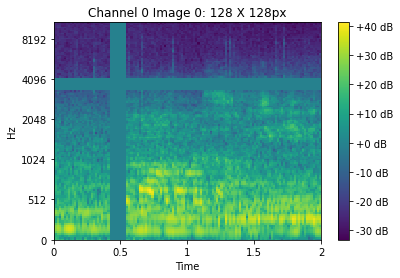

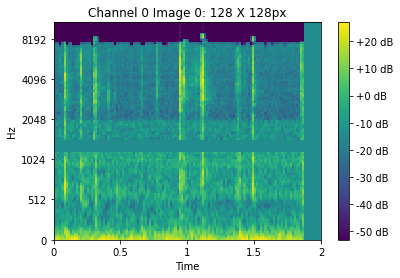

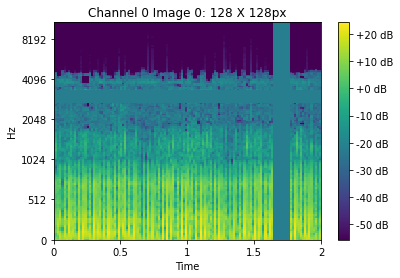

Race_car_and_auto_racing
Computer_keyboard
Purr


In [37]:
dls.show_batch(max_n=3)

## Training

Now that we have our `Dataloaders`, we need to make a model. We'll make a function that changes a `Learner`'s first layer to accept a 1 channel input.

Let's make an audio_learner function which is similar to a cnn_learner. In addition, the learner will need the Binary Cross Entropy Loss, so we will need to combine both the approach from the fastai multicat notebook:

https://github.com/fastai/fastbook/blob/master/06_multicat.ipynb

and the fastai2 audio learner creation.

This will need the following steps:



1.   Create a standard CNN Learner
2.   Get the activation sizes from a single mini-batch
3. Pass the activation sizes to the BCELoss Function
4. Pass the BCE Loss function to the `audiolearner` function, which augments the Leaner to accept a single channel input




**Note on Multi-category Loss Function**

Fastbook:

>We also saw that the model in a Learner is generally an object of a class inheriting from nn.Module, and that you can call it using parentheses and it will return the activations of a model. You should pass it your independent variable, as a mini batch. We can try it out by grabbing a mini batch from our DataLoader, and then passing it to the model:

>Note that because we have a one-hot encoded dependent variable, we can't directly use nll_loss or softmax (and therefore we can't use cross_entropy).

>Normally for one-hot encoded targets you'll want F.binary_cross_entropy_with_logits (or nn.BCEWithLogitsLoss), which do both sigmoid and binary cross entropy in a single function, as in our example above.

***With a standard learner, we don't normally need to tell fastai to use this loss function since it will be automatically chosen for us using the DataLoaders recognising multiple category labels. However, as we are creating an audio_learner, we need to provide the loss function to the audio_learner() function defined above.***

>One change compared to the last chapter is the metric we use: since we are in a multilabel problem, we can't use the accuracy function

>The class predicted was the one with the highest activation (this is what argmax does). Here it doesn't work because we could have more than one prediction on a single image. After applying the sigmoid to our activations (to make them between 0 and 1), we need to decide which ones are 0s and which ones are 1s by picking a threshold. Each value above the threshold will be considered as a 1, and each value lower than the threshold will be considered a 0. 

>If we pass accuracy_multi directly as a metric, it will use the default value for threshold, which is 0.5. We might want to adjust that default and create a new version of accuracy_multi that has a different default. 

>Picking a threshold is important. If you pick a threshold that's too low, you'll often be failing to select correctly labelled objects. If you pick a threshold that's too high, you'll often be selecting correctly labelled objects. We can see this by changing our metric, and then calling validate, which returns the validation loss and metrics. 

In this case, we're going to use BCEWithLogitsLossFlat():

```"Same as `nn.CrossEntropyLoss`, but flattens input and target."```

say the fastai docs - double check.

Also, we change the output to be 80 neurons to match the label amount.


## Create our AudioLearner

Below are different options for learners - for experimentation

In [0]:
### OPTION 1 - Pretrained 1-channel xresnet50 with multi-accuracy

# Custom cnn model created from pretrained xresnet18 (smaller model for inference speed)
# 1 input channel and 80 output nodes
# torch.nn.BCEWithLogitsLoss() = Binary Cross Entropy Loss from pytorch
# accuracy_multi for multi label

model = create_cnn_model(xresnet18, n_in=1, n_out=80, pretrained=True)

learn = Learner(dls, model, BCEWithLogitsLossFlat(), metrics=accuracy_multi) # pass custom model to Learner

SuggestedLRs(lr_min=0.07585775852203369, lr_steep=0.033113110810518265)

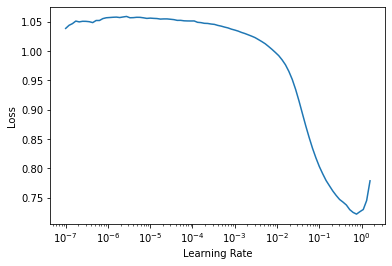

In [42]:
# find the learning rate
learn.lr_find()

In [43]:
# fit with one_cyle learning rate policy
learn.fit_one_cycle(10, 3e-2)

epoch,train_loss,valid_loss,accuracy_multi,time
0,0.439350,0.116573,0.985534,04:43
1,0.154989,0.105193,0.984224,04:44
2,0.096534,0.074629,0.982586,04:47
3,0.071826,0.061563,0.985257,04:45
4,0.059532,0.056486,0.984577,04:44
5,0.052819,0.054463,0.985333,04:44
6,0.048778,0.047426,0.986517,04:48
7,0.043911,0.038555,0.987273,04:47
8,0.039709,0.035478,0.988558,04:45
9,0.036798,0.033669,0.989037,04:44


In [0]:
# Save the stage 1 model to allow quick fine tuning experimentation
learn.save('xresnet50-stage-1-model-frozen')

Now let's unfreeze the base model and train on the whole network:

SuggestedLRs(lr_min=6.309573450380412e-08, lr_steep=1.5848931980144698e-06)

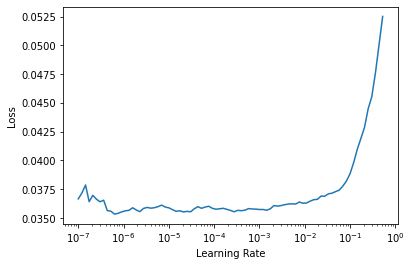

In [45]:
learn.unfreeze()
learn.lr_find()

In [46]:
learn.fit_one_cycle(10, lr_max=slice(1e-5,1e-3))

epoch,train_loss,valid_loss,accuracy_multi,time
0,0.035296,0.032883,0.989314,04:43
1,0.035404,0.033168,0.989289,04:44
2,0.035291,0.031552,0.989617,04:44
3,0.034840,0.033127,0.989163,04:42
4,0.034015,0.032118,0.989516,04:42
5,0.033034,0.031398,0.989642,04:42
6,0.032595,0.031263,0.989718,04:44
7,0.032183,0.031861,0.989819,04:47
8,0.031888,0.029467,0.990197,04:49
9,0.031657,0.030350,0.989718,04:44


In [0]:
# Save the stage 2 model
path = '/content/drive/My Drive/Machine_Learning/My_Projects/19011 - Audio Classifier Web App/xresnet50-stage-2-model-finetuned'
learn.save(file=path, with_opt=True)

## Export the model and upload to S3

Now that we have trained our model we will export it using the learner method `export()` and upload the exported model to S3.

In [0]:
learn.export()

Now let's create a tarfile for our model.

In [0]:
import tarfile
with tarfile.open(path/'model.tar.gz', 'w:gz') as f:
    f.add(path/'export.pkl', arcname='model.pkl')

In [0]:
import sagemaker

role = sagemaker.get_execution_role()
sess = sagemaker.Session()

In [0]:
prefix = 'DEMO-fastai2-sagemaker-oxford-pets'

Now we will upload the model to the default S3 bucket for sagemaker.

In [0]:
model_location = sess.upload_data(str(path/'model.tar.gz'), key_prefix=prefix)
model_location

## Script for model inference

SageMaker invokes the main function defined within your training script for training. When deploying your trained model to an endpoint, the `model_fn()` is called to determine how to load your trained model. The `model_fn()` along with a few other functions list below are called to enable predictions on SageMaker.

### [Predicting Functions](https://github.com/aws/sagemaker-pytorch-containers/blob/master/src/sagemaker_pytorch_container/serving.py)
* `model_fn(model_dir)` - loads your model.
* `input_fn(serialized_input_data, content_type)` - deserializes predictions to predict_fn.
* `output_fn(prediction_output, accept)` - serializes predictions from predict_fn.
* `predict_fn(input_data, model)` - calls a model on data deserialized in input_fn.

Here is the full code in a file `serve.py` showing implementations of the 4 key functions:

In [0]:
!pygmentize scripts/serve.py

## Deploy locally to test

Before deploying to Amazon SageMaker we want to verify that the endpoint is working properly. The Amazon SageMaker Python SDK allows us to deploy locally to the Notebook instance using Docker. We will create the model then specify the parameter `instance_type` to be `local` telling the SDK to deploy locally.

In [0]:
from sagemaker.pytorch import PyTorchModel

model = PyTorchModel(model_data=model_location,
                     role=role,
                     framework_version='1.4.0',
                     entry_point='serve.py', 
                     source_dir='scripts')

Now that we have created the model we will deploy locally to test. It may take a while to run the first time as we need to download a Docker image to our notebook instance.

In [0]:
predictor = model.deploy(initial_instance_count=1, instance_type='local')

Now we can test out our endpoint. We will download a cat images from the internet and save locally.

In [0]:
! [ -d tmp ] || mkdir tmp
! wget -q -O tmp/british-shorthair.jpg https://cdn1-www.cattime.com/assets/uploads/2011/12/file_2744_british-shorthair-460x290-460x290.jpg

In [0]:
img = Image.open('tmp/british-shorthair.jpg')
img

Now we can call our local endpoint to ensure it is working and provides us the correct result.

In [0]:
from sagemaker.predictor import json_serializer, json_deserializer

predictor.accept = 'application/json'
predictor.content_type = 'application/json'

predictor.serializer = json_serializer
predictor.deserializer = json_deserializer

response = predictor.predict( { "url": "https://cdn1-www.cattime.com/assets/uploads/2011/12/file_2744_british-shorthair-460x290-460x290.jpg" })

print(response)

Once you are happy that the endpoint is working suceessully you can shut it down.

In [0]:
predictor.delete_endpoint()

## Deploy to SageMaker

Once we have verified that the script is working successfully on our locally deployed endpoint we can deploy our model to Amazon SageMaker so that it can be used in a production application. The code is almost exactly the same as deploying locally except that when we call `model.deploy()` we will change the instance type to an Amazon SageMaker valid instance type (e.g. `ml.m5.xlarge`).

In [0]:
from sagemaker.pytorch import PyTorchModel

model = PyTorchModel(model_data=model_location,
                     role=role,
                     framework_version='1.4.0',
                     entry_point='serve.py', 
                     source_dir='scripts')

Now let's deploy our SageMaker endpoint. It will take a few min to provision.

In [0]:
predictor = model.deploy(initial_instance_count=1, instance_type='ml.m5.xlarge')

In [0]:
img = Image.open('tmp/british-shorthair.jpg')
img

Now let's test our remote endpoint running on SageMaker hosting services.

In [0]:
from sagemaker.predictor import json_serializer, json_deserializer

predictor.accept = 'application/json'
predictor.content_type = 'application/json'

predictor.serializer = json_serializer
predictor.deserializer = json_deserializer

response = predictor.predict( { "url": "https://cdn1-www.cattime.com/assets/uploads/2011/12/file_2744_british-shorthair-460x290-460x290.jpg" })

print(response)

## Optional: delete endpoint

If you do not want to keep the endpoint up and running then remember to delete it to avoid incurring further costs.

In [0]:
predictor.delete_endpoint()